In [1]:
import warnings
warnings.filterwarnings("ignore")

from config import get_config
from train import train_model

import torch
#import inference_helpers

import json

In [ ]:
## randomized search
num_models = 1
best_model_params = []
for k in range(1, num_models+1):
    print(f"MODEL CROSS VALIDATING - #{k}")
    print(20*"--")
    config = get_config()
    config["model_folder"] = "cv_weights"
    config["experiment_name"] = "cv_run/tmodel"
    config["run"] = "cv_run"

    param_grid = {
        "d_ff": [64, 128, 256, 512],
        "Nx": [2, 4, 6],
        "n_head": [2],
        "dropout": [0.1, 0.2, 0.5]
    }
    config["tgt_step"] = k-1

    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    res, best_params, best_score = grid_search(config, device, lr_cv = 5*10**-5, n_epoch = 10, param_grid = param_grid)
    best_model_params.append(best_params)
    print("Best params:", str(best_params))
    print(20*"--")

with open(f"param.json", "w") as outfile: 
    json.dump({"params": param_grid, "best_params": best_model_params}, outfile)

In [2]:
cfg = get_config()

if cfg['tgt_seq_len'] < cfg['val_seq_len']:
    raise ValueError("Tensors must have the same shape.")

print(f"MODEL TRAINING")
print(20*"-")
cfg['preload'] = None
cfg['num_epochs'] = 20

cfg["run"] = "test"
cfg['model_folder'] += cfg['run']
cfg['experiment_name'] = f"runs{cfg['run']}/tmodel"

model, summary = train_model(cfg)
print(20*"-")

MODEL TRAINING
--------------------
Using device: cpu


Processing Epoch 00: 100%|██████████| 626/626 [03:14<00:00,  3.21it/s, loss=49082.801]


Training loss of epoch 0: 33489.04967052716


Processing Epoch 01: 100%|██████████| 626/626 [03:26<00:00,  3.04it/s, loss=73824.750]


Training loss of epoch 1: 33452.26318827376


Processing Epoch 02: 100%|██████████| 626/626 [03:22<00:00,  3.09it/s, loss=12295.146]


Training loss of epoch 2: 33183.22973086811


Processing Epoch 03: 100%|██████████| 626/626 [02:59<00:00,  3.48it/s, loss=11803.733]


Training loss of epoch 3: 32987.38299814048


Processing Epoch 04: 100%|██████████| 626/626 [02:32<00:00,  4.11it/s, loss=94059.367]


Training loss of epoch 4: 32906.13966403754


Processing Epoch 05: 100%|██████████| 626/626 [02:34<00:00,  4.04it/s, loss=35091.535]


Training loss of epoch 5: 32594.65592239916


Processing Epoch 06: 100%|██████████| 626/626 [02:28<00:00,  4.20it/s, loss=14674.684]


Training loss of epoch 6: 32345.255772014778


Processing Epoch 07:  35%|███▌      | 221/626 [01:08<02:05,  3.24it/s, loss=37853.953]


KeyboardInterrupt: 

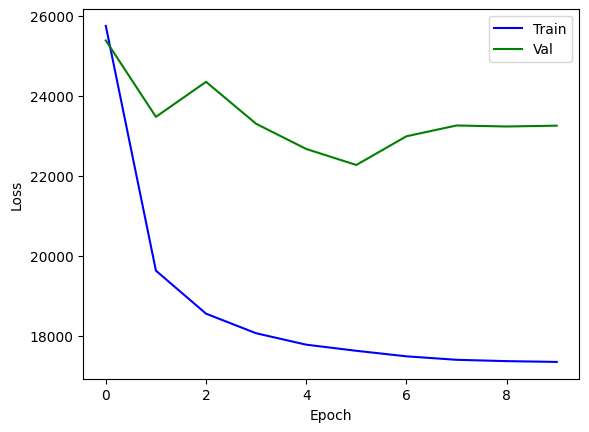

In [6]:
cfg['run'] = 'test'

gen_path = f'./loss/run{cfg["run"]}/'
loss_paths = [f'{gen_path}training_loss.txt', f'{gen_path}val_loss.txt']

files = {'train': None, 'val': None}
for file_path, loss_key in zip(loss_paths, files.keys()):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        float_lines = list(map(float, lines))
        files[loss_key] = float_lines

d = [i for i in range(len(files['train']))]

plt.figure()
plt.plot(d, files['train'], label="Train", color='b')
plt.plot(d, files['val'], label="Val", color='g')

# Add labels and legend
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Show the plot
plt.show()